In [1]:
%matplotlib inline
import sys
import os
import time
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from dask.distributed import Client

import uproot
import uproot_methods
import awkward
from awkward import JaggedArray

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
from coffea.processor import LazyDataFrame
import coffea.processor as processor

from condor_utils import submit_workers

In [2]:
scheduler_url = "uaf-10.t2.ucsd.edu:50123"
if False:
    submit_workers(scheduler_url,
                   dry_run=True,
                   num_workers=20,
                   blacklisted_machines=[
                       "sdsc-18.t2.ucsd.edu",
                       "sdsc-20.t2.ucsd.edu",
                        "cabinet-7-7-36.t2.ucsd.edu",
    #                     "cabinet-8-8-1.t2.ucsd.edu",
                        "cabinet-4-4-18.t2.ucsd.edu",
                   ])

In [3]:
import htcondor
myads = list(map(dict,htcondor.Schedd().query('JobBatchName=="daskworker"')))
df = pd.DataFrame(myads)[["JobStatus","RemoteHost"]]
print(df.JobStatus.value_counts())
df.head()

2    157
1     44
Name: JobStatus, dtype: int64


,JobStatus,RemoteHost
0,2,slot1_7@glidein_145283_441129600@sdsc-65.t2.uc...
1,2,slot1_8@glidein_36513_36009972@cabinet-3-3-4.t...
2,2,slot1_1@glidein_195182_25954435@cabinet-5-5-2....
3,2,slot1_7@glidein_71600_99703512@cabinet-0-0-21....
4,2,slot1_4@glidein_66507_272259000@cabinet-3-3-1....


In [4]:
c = Client(scheduler_url)
c

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 157 Cores: 157 Memory: 785.00 GB


In [5]:
# c.restart()
# def f():
#     import gc
#     gc.collect()
# c.run(f)

In [6]:
%%html
<iframe src="http://localhost:8787/status" width="100%" height="500px"></iframe>

In [7]:
%%time
# use_xrootd = True
use_xrootd = False
fnames = sorted(glob.glob("/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run201*-Nano1June2019-v*/*.root"))
if use_xrootd:
    fnames = [fname.replace("/hadoop/cms","root://redirector.t2.ucsd.edu/") for fname in fnames]
    
print(len(fnames))
print(fnames[:3])

397
['/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run2016C-Nano1June2019-v1/00620178-A54D-F04E-8A7D-40D98C84639D.root', '/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run2016C-Nano1June2019-v1/1B63F0BC-812A-C644-81A0-15B11CCFE3CA.root', '/hadoop/cms/store/group/snt/nanoaod/DoubleMuon__Run2016C-Nano1June2019-v1/2F603B05-20C5-2F4C-BDF5-E7D7DA77828E.root']
CPU times: user 11 ms, sys: 3 ms, total: 14 ms
Wall time: 425 ms


In [8]:
# From https://github.com/CoffeaTeam/coffea/blob/master/binder/muonspectrum_v4.ipynb
class FancyDimuonProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        mass_axis = hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 600, 0.25, 300)
        pt_axis = hist.Bin("pt", r"$p_{T,\mu}$ [GeV]", 3000, 0.25, 300)
        
        self._accumulator = processor.dict_accumulator({
            'mass': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_near': hist.Hist("Counts", dataset_axis, mass_axis),
            'mass_far': hist.Hist("Counts", dataset_axis, mass_axis),
            'pt_lead': hist.Hist("Counts", dataset_axis, pt_axis),
            'pt_trail': hist.Hist("Counts", dataset_axis, pt_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            'workers': processor.set_accumulator(),
        })
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        try:
            from dask.distributed import get_worker
            output["workers"].add(get_worker().name)
        except:
            pass
    
        
        dataset = df['dataset']
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'],
            eta=df['Muon_eta'],
            phi=df['Muon_phi'],
            mass=df['Muon_mass'],
            charge=df['Muon_charge'],
            softId=df['Muon_softId'],
            tightId=df['Muon_tightId']
            )        
        
        output['cutflow']['all events'] += muons.size
        
        soft_id = (muons.softId > 0)
        muons = muons[soft_id]
        output['cutflow']['soft id'] += soft_id.any().sum()
        
        twomuons = (muons.counts >= 2)
        output['cutflow']['two muons'] += twomuons.sum()
        
        dimuons = muons[twomuons].distincts()
        
        twodimuons = (dimuons.counts >= 2)
        output['cutflow']['>= two dimuons'] += twodimuons.sum()
        dimuons = dimuons[twodimuons]
        
        opposite_charge = (dimuons.i0['charge'] * dimuons.i1['charge'] == -1)
        
        dimuons = dimuons[opposite_charge]
        output['cutflow']['opposite charge'] += opposite_charge.any().sum()
        
        mass_20GeV = (dimuons.mass > 35)
        dimuons = dimuons[mass_20GeV]
        
        exactlytwodimuons = (dimuons.counts == 2)
        output['cutflow']['== two dimuons'] += exactlytwodimuons.sum()
        dimuons = dimuons[exactlytwodimuons].compact()
        
        leading_mu = (dimuons.i0.pt.content > dimuons.i1.pt.content)
        pt_lead = JaggedArray.fromoffsets(dimuons.offsets, np.where(leading_mu, 
                                                                    dimuons.i0.pt.content, dimuons.i1.pt.content))
        pt_trail = JaggedArray.fromoffsets(dimuons.offsets, np.where(~leading_mu, 
                                                                     dimuons.i0.pt.content, dimuons.i1.pt.content))
        
        near_z = np.abs(dimuons.mass - 91.118).argmin()
        far_z = np.abs(dimuons.mass - 91.118).argmax()
        
        output['mass'].fill(dataset=dataset,
                            mass=dimuons.p4.sum().mass)
        output['mass_near'].fill(dataset=dataset, 
                                 mass=dimuons.mass[near_z].flatten())
        output['mass_far'].fill(dataset=dataset, 
                                mass=dimuons.mass[far_z].flatten())
        output['pt_lead'].fill(dataset=dataset,
                               pt=pt_lead.flatten())
        output['pt_trail'].fill(dataset=dataset,
                                pt=pt_trail.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [9]:
tstart = time.time()    

fileset = {
    'DoubleMuon': fnames[:500],
#     'DoubleMuon': fnames[:100],
#     'DoubleMuon': fnames[:1],
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=FancyDimuonProcessor(),
                                  
#                                   executor=processor.iterative_executor,
#                                   executor_args=dict(flatten=True),
#                                   chunksize=500000,
                                  
                                  executor=processor.dask_executor,
                                  executor_args=dict(
                                      client=c,
                                      flatten=True,
                                      savemetrics=True,
                                  ),
                                  chunksize=1000000,
                                 )

elapsed = time.time() - tstart

print("\n")
print("{nworkers} total workers".format(nworkers=len(output[0]["workers"])))
print("{events:g} events in {dt:.1f}s @ {rate:.1f}kHz, including chunking".format(
    events=output[1]["entries"].value,
    dt=elapsed,
    rate=output[1]["entries"].value/elapsed/1e3,
))
print("Event rate per worker, excluding chunking and file/tree open: {rate:.1f}kHz".format(
    rate=output[1]["entries"].value/output[1]["processtime"].value/1e3,
))

[########################################] | 100% Completed |  1min 46.3s

157 total workers
5.68205e+08 events in 166.6s @ 3411.6kHz, including chunking
Event rate per worker, excluding chunking and file/tree open: 44.7kHz


In [10]:
output

({'mass': <Hist (dataset,mass) instance at 0x7fb441c97be0>,
  'mass_near': <Hist (dataset,mass) instance at 0x7fb448c58e80>,
  'mass_far': <Hist (dataset,mass) instance at 0x7fb554fd3828>,
  'pt_lead': <Hist (dataset,pt) instance at 0x7fb441ca8c50>,
  'pt_trail': <Hist (dataset,pt) instance at 0x7fb441ca8cf8>,
  'cutflow': defaultdict_accumulator(int,
                          {'all events': 568204868,
                           'soft id': 535858983,
                           'two muons': 415159257,
                           '>= two dimuons': 114392273,
                           'opposite charge': 101901129,
                           '== two dimuons': 5504294}),
  'workers': {'tcp://169.228.130.149:35039',
   'tcp://169.228.130.149:36933',
   'tcp://169.228.130.149:38378',
   'tcp://169.228.130.149:43050',
   'tcp://169.228.130.214:43663',
   'tcp://169.228.130.216:33006',
   'tcp://169.228.130.216:35711',
   'tcp://169.228.130.216:35941',
   'tcp://169.228.130.216:37306',
   'tcp:

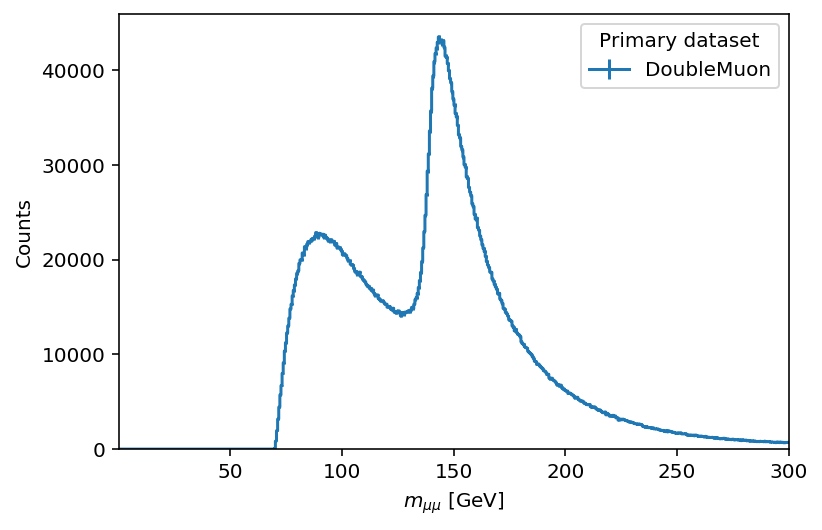

In [11]:
fig, ax, _ = hist.plot1d(output[0]['mass'], overlay='dataset')